In [14]:
import seaborn as sns
import pandas as pd
import pylab as plt
import numpy as np
import os
import tensorflow as tf
from IPython import display
from sklearn import metrics
import glob
import sys
from riotwatcher import RiotWatcher
import requests
import json

api_file = os.path.join('..','..','apikeys','LOL_api_key.txt')
with open(api_file, 'r') as fin:
    watcher = RiotWatcher(fin.readline())

tf.logging.set_verbosity(tf.logging.ERROR)

### Get all champs in game from static data file (.json)

In [12]:
champfile=os.path.join('lol_data','version6.24.1_champion.json')
with open(champfile,'r') as fin:
    champdata=json.load(fin)

In [13]:
champ_vocab=[]
for name,data in champdata['data'].items():
    champ_vocab.append(data['key'])
champ_vocab = [int(i) for i in champ_vocab]

## Input pipeline for tfrecord data

In [258]:
def _parse_function(record):
    """Extracts features and labels.
  
    Args:
        record: File path to a TFRecord file    
      Returns:
    A `tuple` `(labels, features)`:
      features: A dict of tensors representing the features
      labels: A dict of tensors with the corresponding labels.
    """
    features = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8-bit ints for heroes
        "blue_win" :tf.FixedLenFeature([], dtype=tf.int64),
        "gold_diff": tf.FixedLenFeature([], dtype=tf.float32)
                }
  
    parsed_features = tf.parse_single_example(record, features)
  
    blue_champs = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    red_champs = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    blue_win = parsed_features['blue_win']
    gold_diff = parsed_features['gold_diff']
    

    return  {'blue_champs':blue_champs, 'red_champs':red_champs},\
            {'blue_win':blue_win, 'gold_diff':gold_diff}

In [251]:
# Create an input_fn that parses the tf.Examples from the given files,
# and split them into features and targets.
def _input_fn(input_filenames, num_epochs=None, shuffle=True, batch_size=50):
   
    #create a dataset and map features and labels.
    ds = tf.data.TFRecordDataset(input_filenames)
    ds = ds.map(_parse_function)

    if shuffle:
        ds = ds.shuffle(10000)

    # Our feature data is variable-length, so we pad and batch
    # each field of the dataset structure to whatever size is necessary.
    ds = ds.padded_batch(batch_size, ds.output_shapes)
    ds = ds.repeat(num_epochs)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [252]:
# Create the Dataset object.
ds = tf.data.TFRecordDataset(os.path.join('LOL_data','mix_tier',
                                          'lol_training_data',
                                          'dual_gold_win_lol_training_data.tfrecords'))
# Map features and labels with the parse function.
ds = ds.map(_parse_function)
ds = ds.shuffle(10000)
ds

<DatasetV1Adapter shapes: ({blue_champs: (?,), red_champs: (?,)}, {blue_win: (1,), gold_diff: (1,)}), types: ({blue_champs: tf.int64, red_champs: tf.int64}, {blue_win: tf.int64, gold_diff: tf.float32})>

In [253]:
n = ds.make_one_shot_iterator().get_next()
sess = tf.Session()
sess.run(n)

({'blue_champs': array([119,  53,  14, 107,  31]),
  'red_champs': array([157,  58,  60,  25,  67])},
 {'blue_win': array([1]), 'gold_diff': array([0.30443048], dtype=float32)})

# Define and train dual head linear (or dnn) model

### Define feature column constructor functions

In [7]:
def construct_hero_categorical_columns(keys,vocab):
    """Construct categorical features for all features
        Args: 
            input_features: names of input feature columns to use
        returns:
            a set of categorical columns
    """
    return set([tf.feature_column.categorical_column_with_vocabulary_list(key,
                                                                     vocabulary_list = vocab,
                                                                     num_oov_buckets =0)
                                    for key in keys])                                                               

In [8]:
def construct_indicator_columns(feature_columns):
    """Construct indicator columns for all features
            from categorical columns
        Args: 
            feature_columns: Set of 'tf.feature_column.categorical_column'
                to convert to indicator columns
        returns:
            a list of indicator columns
    """
    indicator_columns = []
    for column in list(feature_columns):
        indicator_columns.append(tf.feature_column.indicator_column(column))
        
    return indicator_columns      

In [9]:
def construct_embedding_columns(feature_columns, dimension):
    """Construct embedding columns for all features
            from categorical columns
        Args:
            feature_columns: `Set` of 'tf.feature_column.categorical_column'
                to convert to embedding columns
            dimension: `int` that shows the 
        returns:
            a list of embedding columns
    """
            
    embedding_columns = []
    for column in list(feature_columns):
        embedding_columns.append(tf.feature_column.embedding_column(column,dimension=dimension))
        
    return embedding_columns

## Define input pipeline for dual labels

## Define model function

### Define model function for soft parameter sharing

In [284]:
# In `dual_head_model`, specify logits as a dict keyed by head name:
def dual_head_model(features, labels, mode, params):
    """Estimator for a dual binary classifier and regressor. 
    The loss is a linear combination of the softmax cross entropy
    of the classifier and the huber loss of the regressor.
    
    Args:
        features: `dict` batch_features from an input_fn.
        labels: `dict` of batch_labels for win from an input_fn.
        mode: `str` specifying tf.Estimator mode (e.g. Train, Eval, Predict).
        params: `dict` of params with elements: feature_columns, hidden_units_gold,
                    hidden_units_win, win_loss_weight.
            feature_columns: A `set` specifying the input feature columns to use.
            optimizer: A `tf.train.Optimizer` to use
            hidden_units_gold: A `list` of `int`s for layer sizes for gold dnn. 
                    An empty list makes a linear model.
            hidden_units_win: A `list` of `int` for the win dnn.
            win_loss_weight: `float` Weight from [0,1] for the win_loss 
                    relative to the gold_loss (weighted as 1-win_loss_weight).
    returns: 
        A tf.estimator object
    """

    #initialize net_gold and net_win as the input_layer
    net_gold = tf.feature_column.input_layer(features, params['feature_columns'])
    net_win = tf.feature_column.input_layer(features, params['feature_columns'])

    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    layer_list_gold =[]
    layer_list_win=[]
    for units in params['hidden_units']:
        layer_list.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net_gold = layer_list_gold[-1](net_gold)
        layer_list_win.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net_win = layer_list_win[-1](net_win)  
     # Compute logits gold (1 because it is just the predicted diff).
    logits_gold = tf.layers.dense(net_gold, 1, activation=None,
                                  trainable=True, name='output_gold')
    # Compute logits win (win or lose).
    logits_win = tf.layers.dense(net_win, 2, activation=None, 
                                 trainable=True, name='output_win')

    #collect logits into a single dict
    logits = {'gold_head':logits_gold, 'win_head':logits_win}
    
    # Compute predictions.
    predicted_win = tf.argmax(logits['win_head'], 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'classes': predicted_things[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits['win_head']),
            'logits_win': logits['win_head'],
            'gold': logits['gold_head']
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss.
    labels['blue_win'] = tf.one_hot(labels['blue_win'],2)
    win_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels['blue_win'],
                                               logits=logits['win_head'])
    gold_loss = tf.losses.huber_loss(labels=labels['gold_diff'],
                                     predictions=tf.reshape(logits['gold_head'],[-1]))
    
    #Scale loss_win to weight it more heavily or equal to loss_gold
    #loss_gold starts at 1 because of the z_score normalization we did
    loss_weight=params['win_loss_weight']
    loss = tf.losses.compute_weighted_loss([win_loss,gold_loss],
                                                 weights=[loss_weight,1-loss_weight])
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(tf.gather(labels['blue_win'],1,axis=1),
                                   predicted_win,
                                   name='acc_op')
    auc = tf.metrics.auc(tf.gather(labels['blue_win'],1,axis=1),
                        predicted_win)
    baseline_accuracy = tf.metrics.mean(values=labels['blue_win'])
    metrics = {'accuracy': accuracy,
               'auc': auc,
               'baseline_accuracy': baseline_accuracy}

    tf.summary.scalar('accuracy', accuracy[1])
    tf.summary.scalar('auc', auc[1])
    tf.summary.scalar('loss_win', win_loss)
    tf.summary.scalar('loss_gold', gold_loss)
    tf.summary.scalar('loss', loss)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = params['optimizer']
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### Define model function for hard parameter sharing

In [354]:
# In `dual_head_model`, specify logits as a dict keyed by head name:
def dual_head_model_hardsharing(features, labels, mode, params):
    """Estimator for a dual binary classifier and regressor. 
    The loss is a linear combination of the softmax cross entropy
    of the classifier and the huber loss of the regressor.
    
    Args:
        features: `dict` batch_features from an input_fn.
        labels: `dict` of batch_labels for win from an input_fn.
        mode: `str` specifying tf.Estimator mode (e.g. Train, Eval, Predict).
        params: `dict` of params with elements: feature_columns, hidden_units_gold,
                    hidden_units_win, win_loss_weight.
            feature_columns: A `set` specifying the input feature columns to use.
            optimizer: A `tf.train.Optimizer` to use
            hidden_units_gold: A `list` of `int`s for layer sizes for gold dnn. 
                    An empty list makes a linear model.
            hidden_units_win: A `list` of `int` for the win dnn.
            win_loss_weight: `float` Weight from [0,1] for the win_loss 
                    relative to the gold_loss (weighted as 1-win_loss_weight).
    returns: 
        A tf.estimator object
    """

    #initialize net_gold and net_win as the input_layer
    net = tf.feature_column.input_layer(features, params['feature_columns'])

    # Build the hidden layers, sized according to the 'hidden_units' param.
    # if hidden units is empty then no dense layers (and it is just linear regression)
    layer_list =[]
    for units in params['hidden_units']:
        layer_list.append(tf.layers.Dense(units=units, activation=tf.nn.relu))
        net = layer_list[-1](net)
     # Compute logits gold (1 because it is just the predicted diff).
    logits_gold = tf.layers.dense(net, 1, activation=None,
                                  trainable=True, name='output_gold')
    # Compute logits win (win or lose).
    logits_win = tf.layers.dense(net, 2, activation=None, 
                                 trainable=True, name='output_win')

    #collect logits into a single dict
    logits = {'gold_head':logits_gold, 'win_head':logits_win}
    
    # Compute predictions.
    predicted_win = tf.argmax(logits['win_head'], 1)
    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {
            'classes': predicted_things[:, tf.newaxis],
            'probabilities': tf.nn.softmax(logits['win_head']),
            'logits_win': logits['win_head'],
            'gold': logits['gold_head']
            }
        return tf.estimator.EstimatorSpec(mode, predictions=predictions)
    
    # Compute loss.
    labels['blue_win'] = tf.one_hot(labels['blue_win'],2)
    win_loss = tf.losses.softmax_cross_entropy(onehot_labels=labels['blue_win'],
                                               logits=logits['win_head'])
    gold_loss = tf.losses.huber_loss(labels=labels['gold_diff'],
                                     predictions=tf.reshape(logits['gold_head'],[-1]))
    
    #Scale loss_win to weight it more heavily or equal to loss_gold
    #loss_gold starts at 1 because of the z_score normalization we did
    loss_weight=params['win_loss_weight']
    loss = tf.losses.compute_weighted_loss([win_loss,gold_loss],
                                                 weights=[loss_weight,1-loss_weight])
    
    # Compute evaluation metrics.
    accuracy = tf.metrics.accuracy(tf.gather(labels['blue_win'],1,axis=1),
                                   predicted_win,
                                   name='acc_op')
    auc = tf.metrics.auc(tf.gather(labels['blue_win'],1,axis=1),
                        predicted_win)
    baseline_accuracy = tf.metrics.mean(values=labels['blue_win'])
    metrics = {'accuracy': accuracy,
               'auc': auc,
               'baseline_accuracy': baseline_accuracy}

    tf.summary.scalar('accuracy', accuracy[1])
    tf.summary.scalar('auc', auc[1])
    tf.summary.scalar('loss_win', win_loss)
    tf.summary.scalar('loss_gold', gold_loss)
    tf.summary.scalar('loss', loss)

    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(
            mode, loss=loss, eval_metric_ops=metrics)

    # Create training op.
    assert mode == tf.estimator.ModeKeys.TRAIN

    optimizer = params['optimizer']
    train_op = optimizer.minimize(loss, global_step=tf.train.get_global_step())
    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)

### train function

In [294]:
def train_dual_classifier_regressor(
    steps,
    batch_size,
    params,
    training_file,
    test_file):
    """Trains a linear regression model.
  
    In addition to training, this function also prints training progress information,
    as well as a plot of the training and validation loss over time.
      
    Args:
        target: Target to use for the model (determines whether float and classifier
          vs regressor)
        learning_rate: A `float`, the learning rate.
        steps: A non-zero `int`, the total number of training steps. A training step
          consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int` specifying the size of each training batch
        params: A dict containing kwargs
            optimizer: A `tf.train.Optimizer` to use
            hidden_units_gold: A `list` of `int`s for layer sizes for gold dnn. 
                    An empty list makes a linear model.
            hidden_units_win: A `list` of `int` for the win dnn.
        training_file: A `string` path to the tfrecord training file
        test_file: A `string` path to the tfrecord test file

        
      
    Returns:
        A `LinearEstimator` object trained on the training data.
    """

    periods = 20
    steps_per_period = steps / periods
    
    # Create a linear regressor object.
    dual_model = tf.estimator.Estimator(
        model_fn=dual_head_model_hardsharing,
        params= params
        )
      
  
    training_input_fn =lambda: _input_fn([training_file])
    test_input_fn =lambda: _input_fn([test_file])

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    
    
    training_acc = []
    test_acc = []
    for i in range(periods):
        # Train the model, starting from the prior state.
        dual_model.train(
            input_fn=training_input_fn,
            steps=steps_per_period)
        
        # Take a break and compute predictions.
        evaluation_metrics = dual_model.evaluate(
            input_fn=training_input_fn,
            steps=steps_per_period)
        training_acc.append(evaluation_metrics['loss'])
                            
        evaluation_metrics = dual_model.evaluate(
            input_fn=test_input_fn,
            steps=steps_per_period)    
        test_acc.append(evaluation_metrics['loss'])
        
        print('test loss', evaluation_metrics['loss'])

    print("Test set metrics:")
    for m in evaluation_metrics:
        print(m, evaluation_metrics[m])
    print("---")
    
    plt.plot(training_acc,label='Training loss')
    plt.plot(test_acc,label='Test loss')
    plt.legend()
    plt.show()
    
    return dual_model


### Train a dual head linear classifier and regressor

In [103]:
training_file = os.path.join('LOL_data','mix_tier',
                             'lol_training_data','dual_gold_win_lol_training_data.tfrecords')
test_file = os.path.join('LOL_data','mix_tier',
                         'lol_test_data', 'dual_gold_win_lol_test_data.tfrecords')

categorical_feature_columns = construct_hero_categorical_columns(['blue_champs','red_champs'],champ_vocab)
indicator_feature_columns = construct_indicator_columns(categorical_feature_columns)
embedding_feature_columns = construct_embedding_columns(categorical_feature_columns,dimension=4)

#### Test of blue_win modelling with linear model

Training model...
test loss 0.7049345
test loss 0.7019191
test loss 0.6999529
test loss 0.6984669
test loss 0.6968627
test loss 0.6967381
test loss 0.6957295
test loss 0.69471455
test loss 0.6944741
test loss 0.6936355
test loss 0.69368386
test loss 0.6933016
test loss 0.6924498
test loss 0.69311744
test loss 0.6929666
test loss 0.69258046
test loss 0.693385
test loss 0.69239265
test loss 0.69254667
test loss 0.6917928
Test set metrics:
accuracy 0.5282
auc 0.5264262
baseline_accuracy 0.5
loss 0.6917928
global_step 10000
---


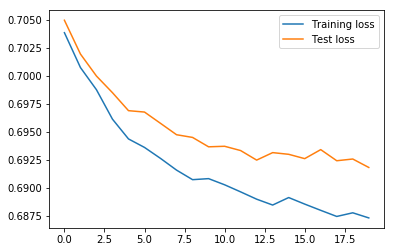

In [287]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=1e4,
    batch_size=1000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.7004074
test loss 0.6966147
test loss 0.69402105
test loss 0.6925746
test loss 0.69181097
test loss 0.690936
test loss 0.6905646
test loss 0.6902783
test loss 0.6899253
test loss 0.6897242
test loss 0.6897868
test loss 0.6896737
test loss 0.6895516
test loss 0.68966305
test loss 0.6892915
test loss 0.6894003
test loss 0.6893538
test loss 0.6894538
test loss 0.6893224
test loss 0.6893968
Test set metrics:
accuracy 0.5340598
auc 0.5334689
baseline_accuracy 0.5
loss 0.6893968
global_step 50000
---


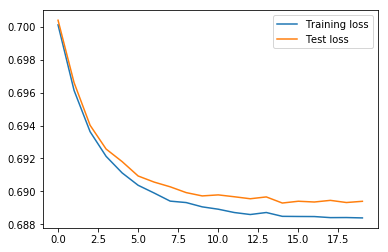

In [288]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.005)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=5e4,
    batch_size=1000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.70105743
test loss 0.6988847
test loss 0.6966899
test loss 0.695897
test loss 0.6946457
test loss 0.6938793
test loss 0.69330657
test loss 0.69287944
test loss 0.69236815
test loss 0.6924736
test loss 0.69177496
test loss 0.6913449
test loss 0.6914746
test loss 0.6910391
test loss 0.69131744
test loss 0.6909679
test loss 0.69099605
test loss 0.69096667
test loss 0.69098824
test loss 0.69118017
Test set metrics:
accuracy 0.52786
auc 0.5271634
baseline_accuracy 0.5
loss 0.69118017
global_step 20000
---


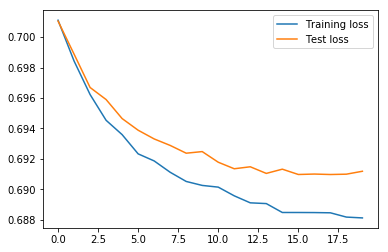

In [289]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.007)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=2e4,
    batch_size=1000,
    params={'hidden_units':[],
            'optimizer':optimizer,
            'feature_columns':indicator_feature_columns,
            'win_loss_weight':1
           },
    training_file=training_file,
    test_file=test_file)

#### Train multi-head dnn

Training model...
test loss 0.31168646
test loss 0.31095782
test loss 0.31076178
test loss 0.31050056
test loss 0.31024906
test loss 0.31016248
test loss 0.310212
test loss 0.3100036
test loss 0.3100091
test loss 0.30994925
test loss 0.31009203
test loss 0.31006098
test loss 0.30997863
test loss 0.3099472
test loss 0.31002477
test loss 0.30987778
test loss 0.30999056
test loss 0.3099491
test loss 0.3099578
test loss 0.31002277
Test set metrics:
accuracy 0.51008
auc 0.49996942
baseline_accuracy 0.5
loss 0.31002277
global_step 30000
---


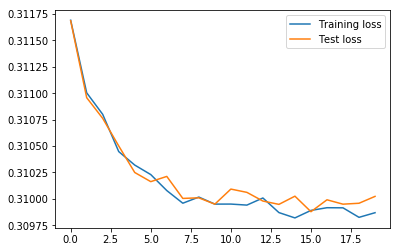

In [338]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=3e-6,
                                          weight_decay = 3e-5)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=3e4,
    batch_size=500,
    params={'hidden_units':[16,16],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.31046218
test loss 0.31028932
test loss 0.31021047
test loss 0.3101351
test loss 0.3101316
test loss 0.31006986
test loss 0.31002626
test loss 0.31004888
test loss 0.31004882
test loss 0.31002253
test loss 0.31000203
test loss 0.30997777
test loss 0.30998275
test loss 0.3099789
test loss 0.30998844
test loss 0.3099312
test loss 0.30998954
test loss 0.3099655
test loss 0.3099456
test loss 0.30994618
Test set metrics:
accuracy 0.5104412
auc 0.5024871
baseline_accuracy 0.5
loss 0.30994618
global_step 100000
---


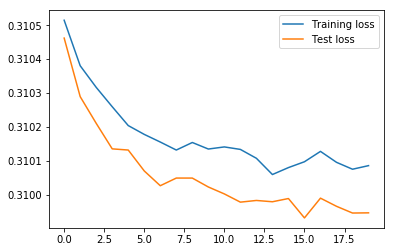

In [348]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=3e-6,
                                          weight_decay = 3e-6)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=10e4,
    batch_size=500,
    params={'hidden_units':[32,32],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.31044903
test loss 0.31033757
test loss 0.3102266
test loss 0.3101884
test loss 0.31013784
test loss 0.31011176
test loss 0.31007332
test loss 0.31006664
test loss 0.31007752
test loss 0.31002277
test loss 0.31002972
test loss 0.30998194
test loss 0.31002486
test loss 0.30998287
test loss 0.3099886
test loss 0.3099973
test loss 0.30997062
test loss 0.30998176
test loss 0.3100207
test loss 0.30996814
Test set metrics:
accuracy 0.51038516
auc 0.50192523
baseline_accuracy 0.5
loss 0.30996814
global_step 100000
---


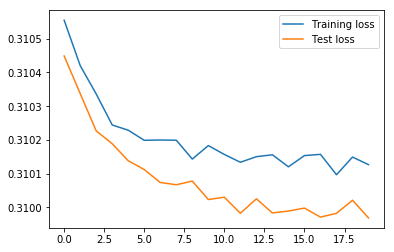

In [355]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=3e-6,
                                          weight_decay = 3e-6)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=10e4,
    batch_size=1000,
    params={'hidden_units':[8,8],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.3103001
test loss 0.31020096
test loss 0.31010908
test loss 0.3100707
test loss 0.31006554
test loss 0.31005368
test loss 0.3100522
test loss 0.31005454
test loss 0.31000856
test loss 0.31002492
test loss 0.3100159
test loss 0.30998376
test loss 0.30999896
test loss 0.3100029
test loss 0.31000352
test loss 0.31001502
test loss 0.3100276
test loss 0.3099805
test loss 0.31000397
test loss 0.30999565
Test set metrics:
accuracy 0.5098171
auc 0.5
baseline_accuracy 0.5
loss 0.30999565
global_step 100000
---


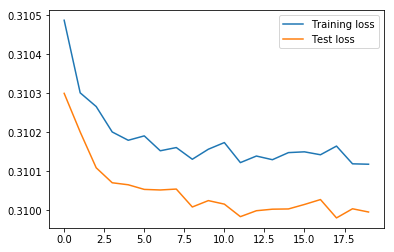

In [356]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=6e-6,
                                          weight_decay = 6e-6)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=10e4,
    batch_size=1000,
    params={'hidden_units':[8,8],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

Training model...
test loss 0.31018886
test loss 0.3099714
test loss 0.30997905
test loss 0.30993986
test loss 0.31000116
test loss 0.3099797
test loss 0.30998528
test loss 0.30992863
test loss 0.3100669
test loss 0.30999967
test loss 0.30995825
test loss 0.30996743
test loss 0.31002942
test loss 0.30998945
test loss 0.309964
test loss 0.31001112
test loss 0.31007665
test loss 0.30995744
test loss 0.31002435
test loss 0.31004816
Test set metrics:
accuracy 0.5107692
auc 0.5
baseline_accuracy 0.5
loss 0.31004816
global_step 50000
---


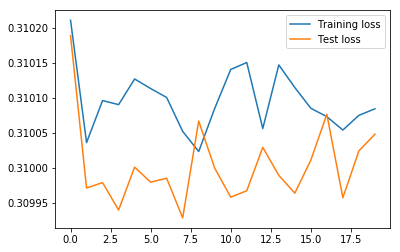

In [357]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=1e-5,
                                          weight_decay = 1e-4)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=5e4,
    batch_size=1000,
    params={'hidden_units':[8,8],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

In [ ]:
optimizer = tf.contrib.opt.AdamWOptimizer(learning_rate=3e-6,
                                          weight_decay = 1e-5)

trained_dualhead_linear_model = train_dual_classifier_regressor(
    steps=10e4,
    batch_size=1000,
    params={'hidden_units':[8,8],
            'optimizer':optimizer,
            'feature_columns':embedding_feature_columns,
            'win_loss_weight':0.7
           },
    training_file=training_file,
    test_file=test_file)

### Validate model
only do this if you're done training!!

In [295]:
validation_file = os.path.join('LOL_data','mix_tier',
                               'lol_validation_data', 
                               'dual_gold_win_lol_validation_data.tfrecords')
validation_input_fn =lambda: _input_fn([validation_file])
evaluation_metrics = trained_dualhead_linear_model.evaluate(
            input_fn=validation_input_fn,
            steps=3e3)
for m in evaluation_metrics:
    print(m, evaluation_metrics[m])

KeyboardInterrupt: 

### Investigate embeding layer

In [79]:
champ_list = interface('IEconDOTA2_570').GetHeroes(itemizedonly = True)['result']['heroes']

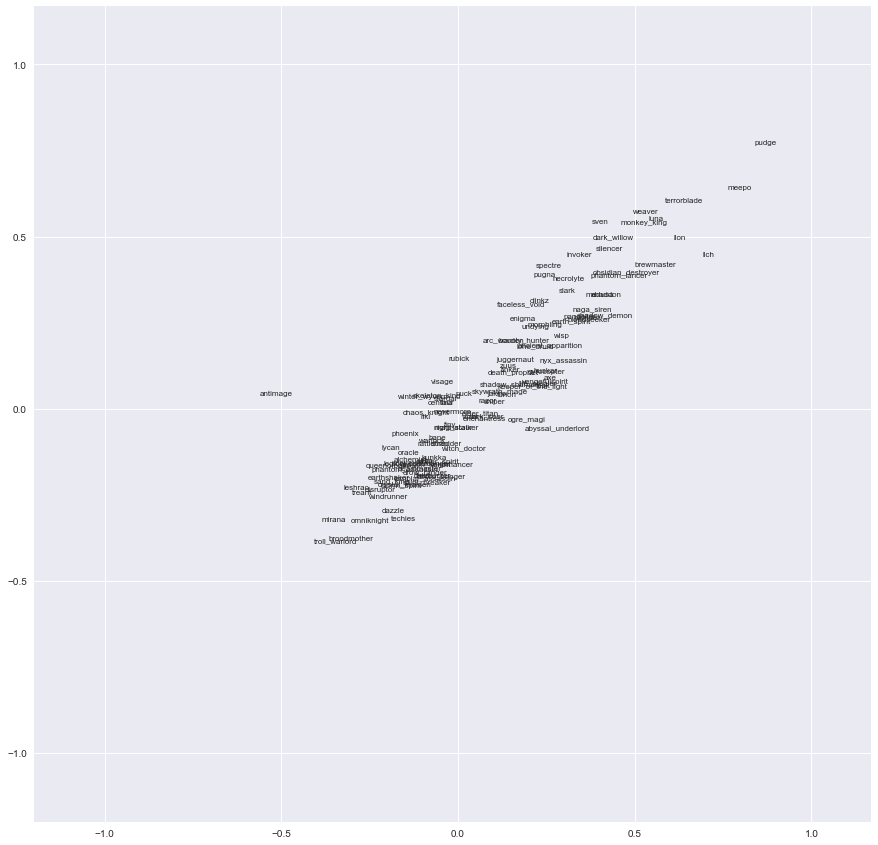

In [85]:
vocab = list(range(105))+list(range(106,114))+list(range(119,121))
red_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/red_champs_embedding/embedding_weights')

blue_embedding_matrix = trained_dnn_model.get_variable_value(
    'dnn/input_from_feature_columns/input_layer/blue_heroes_embedding/embedding_weights')

for champ_index in range(len(vocab)):
    # Create a one-hot encoding for our term. It has 0s everywhere, except for
    # a single 1 in the coordinate that corresponds to that term.
    red_vector = np.zeros(len(vocab))
    red_vector[champ_index] = 1
    blue_vector = np.zeros(len(vocab))
    blue_vector[champ_index] = 1
    # We'll now project that one-hot vector into the embedding space.
    red_embedding_xy = np.matmul(dire_vector, dire_embedding_matrix)
    blue_embedding_xy = np.matmul(dire_vector,dire_embedding_matrix)
    #plt.text(dire_embedding_xy[0],
    #       dire_embedding_xy[1],
    #       hero_list[hero_index]['name'][14:],fontsize=8)
    plt.text(blue_embedding_xy[0],
           blue_embedding_xy[3],
           champ_list[champ_index]['name'][14:],fontsize=8,)

# Do a little setup to make sure the plot displays nicely.
plt.rcParams["figure.figsize"] = (15, 15)
plt.xlim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.ylim(1.2 * red_embedding_matrix.min(), 1.2 * red_embedding_matrix.max())
plt.show() 

### Save a trained model later exploration, or for on-demand prediction of test cases

In [20]:
def serving_input_receiver_fn():
    """An input receiver that expects a serialized tf.Example."""
    feature_spec = {
        "blue_champs": tf.FixedLenFeature([], dtype=tf.string), #array of five 8 bit ints for heroes
        "red_champs": tf.FixedLenFeature([], dtype=tf.string) #array of five 8-bit ints for heroes
                }
    serialized_tf_example = tf.placeholder(dtype=tf.string,
                                         shape=[1],
                                         name='input_example_tensor')
    receiver_tensors = {'examples': serialized_tf_example}
    parsed_features = tf.parse_example(serialized_tf_example, feature_spec)
    
    radiant_heroes = tf.decode_raw(parsed_features['blue_champs'], tf.int64)
    dire_heroes = tf.decode_raw(parsed_features['red_champs'], tf.int64)
    
    features = {'blue_champs':radiant_heroes, 'red_champs': dire_heroes}
    return tf.estimator.export.ServingInputReceiver(features, receiver_tensors)

In [21]:
export_dir = os.path.join('trained_models','dnn_models')
trained_dnn_model.export_savedmodel(
                                export_dir_base = export_dir,
                                serving_input_receiver_fn = serving_input_receiver_fn)

b'trained_models/dnn_models/1554789124'